# Кластеризация

На этом семинаре мы займёмся задачей кластеризации векторов, интерпретацией полученных результатов. В частности, посмотрим на задачу выделения отдельных видов товаров в категории объявлений как на задачу кластеризации.

Нам предстоит: 

* посмотреть на подготовку векторов к кластеризации,
* реализовать алгоритм KMeans и попробовать разные варианты его инициализации,
* изучить примеры интерпретации полученных кластеров,
* ознакомиться с подбором параметров DBSCAN,
* решить задачу разделения категории на виды товаров.

## Задача анализа заголовков в категории «Товары для школы»
Цель — проанализировать, какие товары продаются в данной категории и какие заголовки там бывают для последующего использования этой информации при решении уже какой-то конкретной задачи.

Мы имеем дело с текстовыми данными — чтобы кластеризовать их, нам необходимы вектора. Одними из самых простых методов получения векторов, пригодных для использования в реальных задачах, являются TfidfVectorizer или Word2Vec.

В этом шаге мы воспользуемся моделью Word2Vec, предполагая, что она лучше подходит для смыслового анализа слов.

Пайплайн получения векторов для заголовков из семинара:

In [1]:
import re
import ssl
from urllib import request

import numpy as np
import pandas as pd
from gensim.models import Word2Vec

Данные можно [скачать](https://stepik.org/media/attachments/lesson/535633/titles_for_clustering_original.csv)
    или загрузить по ссылке: 

In [136]:
# загружаем данные
ssl._create_default_https_context = ssl._create_unverified_context

# DATA_URL = 'https://stepik.org/media/attachments/lesson/535633/titles_for_clustering_original.csv'

data = pd.read_csv('./datasets/data_split_into_classes.csv')

In [137]:
data.head(10)

,item_id,image_id,title
0,928428250447,9930449149,Беговая дорожка laufstein corsa automatik
1,172952000262,1770341493,Эллиптический тренажер Torneo Vento C-208
2,1064720000255,11289835148,Эллиптический тренажер
3,660092751953,5126102753,Гантели по 10 кг каждая
4,258603750759,2318932240,Kettler Delta XL
5,90672500084,1318576304,Эллиптический тренажер торнео
6,126675250533,1514869208,"Продам тренажер, телефон в подарок"
7,73635250131,1235842103,Гиря 16
8,922164250068,9856241332,Гребля сидя
9,398470251099,3301326704,Практический новый элиптический тренажер


In [138]:
data.shape

(2456, 3)

In [139]:
data[data.item_id == 367883001098]

,item_id,image_id,title
541,367883001098,3137208199,1000


In [140]:
# предобработка
def preprocessing(text):
    """Делаем предобработку.
    
    - приводим к нижнему регистру
    - удаляем пунктуацию и цифры
    - удаляем английские слова: не имеют большой значимости для данной задачи
    :return: строка обработанного текста
    """
    text = re.sub(r'[\d]', ' ', text.lower())
    return ' '.join(text.split())

data['title'] = data['title'].apply(preprocessing)
# удаляем заголовки, которые стали пустыми после предобработки
# mask = data['title'].apply(lambda x: len(x.split()) > 0)
# data = data[mask]

# data.drop_duplicates('title', inplace=True) - опционально, зависит от цели кластеризации
data = data.reset_index(drop=True)

In [141]:
data.head(10)

,item_id,image_id,title
0,928428250447,9930449149,беговая дорожка laufstein corsa automatik
1,172952000262,1770341493,эллиптический тренажер torneo vento c-
2,1064720000255,11289835148,эллиптический тренажер
3,660092751953,5126102753,гантели по кг каждая
4,258603750759,2318932240,kettler delta xl
5,90672500084,1318576304,эллиптический тренажер торнео
6,126675250533,1514869208,"продам тренажер, телефон в подарок"
7,73635250131,1235842103,гиря
8,922164250068,9856241332,гребля сидя
9,398470251099,3301326704,практический новый элиптический тренажер


In [143]:
data.loc[data['title'] == '', 'title'] = 'a'

In [233]:
# обучение Word2Vec
w2v_corpus = [x.split() for x in data['title']]

w2v_model = Word2Vec(min_count=0, vector_size=3, hs=1, window=1, seed=0)
w2v_model.build_vocab(w2v_corpus)
w2v_model.train(w2v_corpus, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs) 

(37238, 53300)

In [234]:
w2v_model.wv['диск']

array([ 0.08493209, -0.084175  ,  0.02150239], dtype=float32)

In [239]:
np.linalg.norm(w2v_model.wv['гантели'] - w2v_model.wv['тренажер'])

1.0501056

In [240]:
# получение векторов заголовков из векторов слов
w2v_embeddings = []
for title_words in w2v_corpus:
    # не забываем, что некоторые слова могут не быть в словаре Word2Vec из-за выставленного min_count
    title_word_embs = [
        w2v_model.wv[word] 
        for word in title_words 
        if word in w2v_model.wv.key_to_index
    ]
    title_emb = sum(title_word_embs) / len(title_word_embs)
    w2v_embeddings.append(title_emb)
w2v_embeddings = np.vstack(w2v_embeddings)

In [241]:
w2v_embeddings.shape

(2456, 3)

## Визуализация кластеров


In [18]:
import random

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

Часто используются два базовых метода анализа получившихся кластеров:

* Посмотреть на несколько ближайших объектов до каждого центроида, исходя из этого оценить содержимое всего кластера.


In [197]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(w2v_embeddings)

top = 5
clusters = kmeans.labels_
dist_to_centers = euclidean_distances(kmeans.cluster_centers_, w2v_embeddings)
top_most_similar = np.argsort(dist_to_centers)[:, :top]

for clt in np.unique(clusters):
    ids = top_most_similar[clt]
    most_similar_titles = '\n'.join(data.iloc[ids]['title'])
    print(f'Cluster {clt}:\n{most_similar_titles}')

Cluster 0:
набор гантели + штанга w-образная кг
продаю гантели сборные от . до . кг
гантели - кг разборные торнео металл
штанга кг + гантели ( шт по ) + груша и т. д
гиря кг ссср, кг ссср
Cluster 1:
эллиптический тренажер brumer (ferrum/raizer) k
велотренажёр kettler - axos cycle m
продаю эллиптический тренажер domyos ve silver
cardio slim кардиотренажер для ягодиц
kettler crosstrainer vito m -


* Визуализация кластеров в 2D с помощью TSNE — широко распространённый метод визуализации данных высокой размерности. В случае очень большой размерности признакового пространства имеет смысл предварительно уменьшить размерность, например, с помощью PCA, для ускорения вычислений и устранения возможного шума.

In [198]:
# для каждого кластера сэмплируем не более 20 точек для ускорения TSNE и наглядности картинки
sample_i = []
for clt in np.unique(clusters):
    cluster_mask = clusters == clt
    sample_i += random.sample(list(np.where(cluster_mask)[0]), min(20, cluster_mask.sum()))

# берем слайс по sample_i
sample_embeddings = w2v_embeddings[sample_i]
sample_clusters = clusters[sample_i].reshape(-1, 1)
sample_texts = data['title'].values[sample_i]

In [199]:
# обучаем и применяем TSNE
tsne_model = TSNE(perplexity=50, metric='cosine', init='pca', n_iter=2500, random_state=17)
reduced_embeddings = tsne_model.fit_transform(sample_embeddings)

/home/denis/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/denis/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/denis/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


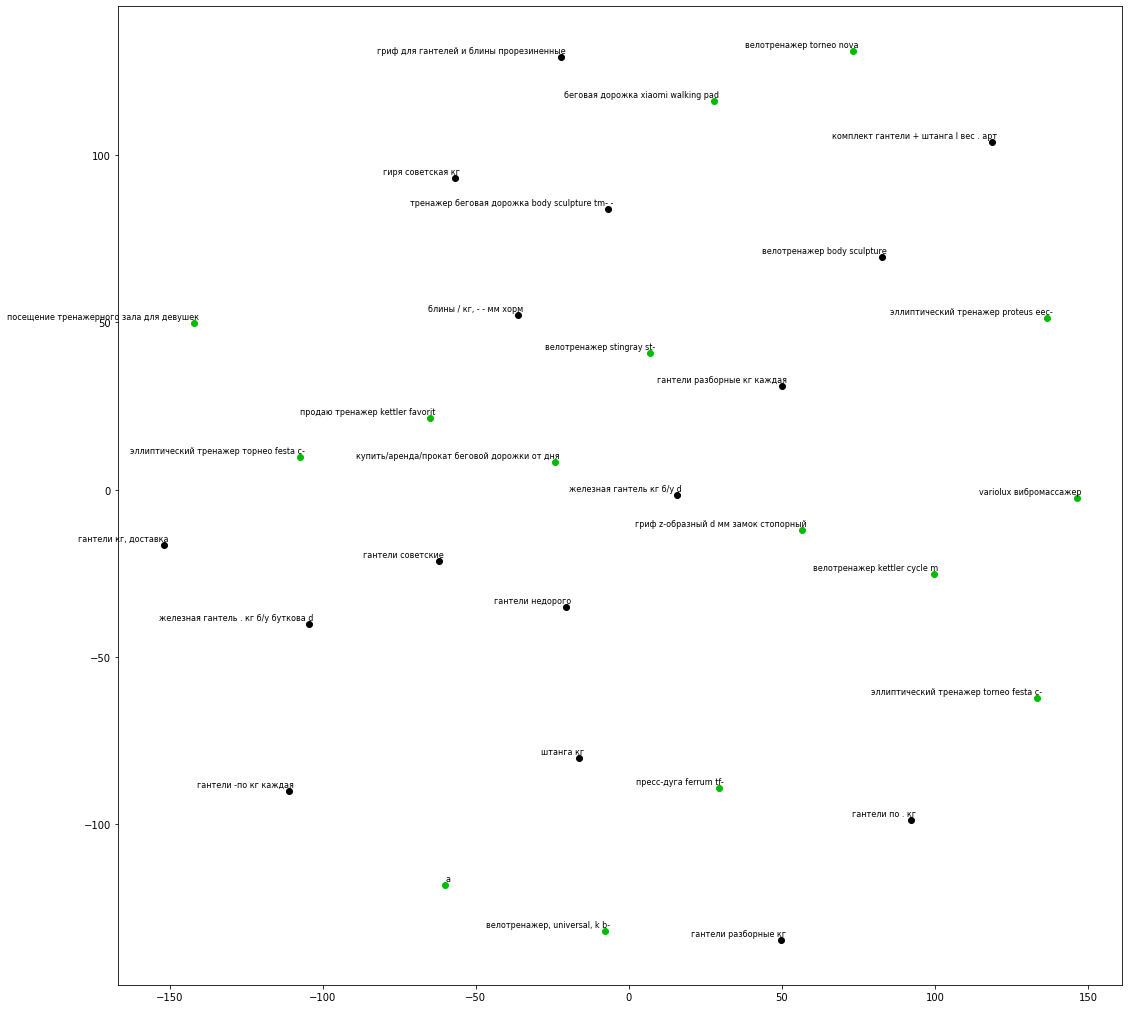

In [200]:
not_annotate_thr=0.3
plt.figure(figsize=(18, 18)) 
colors = cm.nipy_spectral(sample_clusters.astype(float) / len(np.unique(sample_clusters)))
for i, (x, y) in enumerate(reduced_embeddings):
    if np.random.rand() > not_annotate_thr:
        plt.scatter(x, y, c=colors[i])
        plt.annotate(sample_texts[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom', 
                     size=8)
plt.show()

In [32]:
indexes = np.where(sample_texts == 'мини штанга')
indexes

(array([53]),)

In [33]:
sample_texts[indexes]

array(['мини штанга'], dtype=object)

In [34]:
reduced_embeddings[indexes]

array([[ 558.6577  , -126.592896]], dtype=float32)

[Почему так](https://datascience.stackexchange.com/questions/19025/t-sne-why-equal-data-values-are-visually-not-close)

## DBSCAN: краткий обзор

Одним из наиболее часто используемых на практике методов кластеризации при неизвестном количестве кластеров является [DBSCAN](https://ru.wikipedia.org/wiki/DBSCAN)— метод кластеризации, основанный на плотности. 

Метод не применим к данным с большой разницей в плотности кластеров.

Основные преимущества:

1. Не требует априорного знания о необходимом количестве кластеров;
1. Выделяет кластеры произвольной формы;
1. Устойчив к выбросам, выделяет шум.

Подбор параметров

Вся сложность применения метода заключается в подборе двух основных параметров: `min_samples` и `eps`

1. `min_samples` параметр определяет сколько объектов должно содержаться в `eps` окрестности выбранного объекта, чтобы этот объект считалась внутрикластерным. Имеет смысл брать только значения ≥3, на практике часто бывает достаточно ограничить поиски значениями от 3 до 9, но это носит лишь рекомендательный характер и не отрицает наличия оптимальной пары с `eps` вне данного отрезка
1. `eps` параметр определяет размер окрестности. Чтобы больше определиться с областью поиска, для начала нужно выбрать функцию расстояния, так как для ненормированных векторов значения `euclidean_distances` и `cosine_distances` скорее всего лежат в разных диапазонах

Далее можно воспользоваться двумя методами подбора: 
* Метод колена: для выбранного min_samples определяется подходящий eps

*Идея*: для каждого объекта выборки считается расстояние до n-го соседа, где n выбирается равным `min_samples` . После этого расстояния сортируются и отрисовываются. В качестве `eps` берётся значение расстояния в точке с максимальной кривизной, предполагая, что точки с сильно растущим расстоянием до n-го соседа являются выбросами.

Для поиска оптимальной точки можно воспользоваться библиотекой [kneed](https://kneed.readthedocs.io/en/stable/index.html) и ее классом [KneeLocator](https://kneed.readthedocs.io/en/stable/api.html#kneelocator). Суть его заключается в построении интерполирующей функции по заданным точкам (часто из класса полиномиальных функций) и выбора точки (среди заданных) с максимальным значением кривизны полученного интерполянта. В общепринятой формулировке метода колена значения расстояний располагаются в порядке возрастания, следовательно, имеем выпуклую кривую `curve='convex'` с порядком обхода по возрастанию `direction='increasing'`, параметр `interp_method='interp1d'` or `'polynomial'` отвечает методу интерполяции точек.

In [24]:
!pip install kneed

Defaulting to user installation because normal site-packages is not writeable


In [35]:
from sklearn.metrics import pairwise_distances

In [242]:
distances = pairwise_distances(w2v_embeddings)
distances.shape

(2456, 2456)

In [243]:
n = 6

In [244]:
sorted_distances = np.sort(distances, axis=1)
sorted_nth_distanses = np.sort(sorted_distances[:, n - 1])

0.085600585


<Figure size 360x360 with 0 Axes>

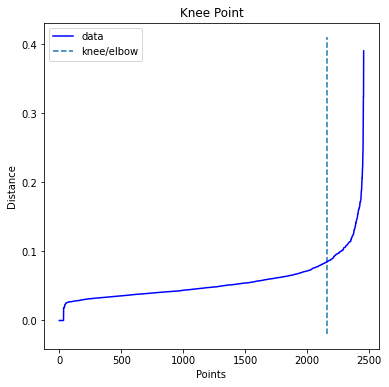

In [245]:
from kneed import KneeLocator
knee = KneeLocator(np.arange(len(sorted_distances)), 
                   sorted_nth_distanses, 
                   curve='convex', 
                   direction='increasing', 
                   interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(sorted_nth_distanses[knee.knee])

В качестве параметров для `DBSCAN` выбираются значения `eps=0.84`, `min_samples=7`, `metric='euclidean'`.

На практике бывает полезно перебрать `eps` в небольшой окрестности найденного оптимального значения из-за зависимости оптимума от выбранного метода и степени интерполяции, попробовать разную интерполяцию и разные значения для n.

* Метод силуэта: 

*Идея*: перебирая по сетке значения для `min_samples` и `eps` , выбрать те, которые приводят к наибольшему значению [силуэт-метрики](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

In [247]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

for eps in np.linspace(0.05, 0.2, 40):
    for ms in [3, 4, 5, 6, 7, 8, 9]:
        clustering = DBSCAN(eps=eps, min_samples=ms, metric='euclidean', n_jobs=-1)
        clusters = clustering.fit_predict(w2v_embeddings)
        if np.unique(clusters).shape[0] < 2:
            continue
        score = silhouette_score(w2v_embeddings, clusters)
        if score > 0.2:
            print(f'number of clusters = {np.unique(clusters).shape[0]}')
            print(f'eps = {eps:0.3f}, ms = {ms}: {score:0.4f}')

number of clusters = 3
eps = 0.077, ms = 9: 0.2047
number of clusters = 3
eps = 0.081, ms = 8: 0.2182
number of clusters = 3
eps = 0.081, ms = 9: 0.2098
number of clusters = 3
eps = 0.085, ms = 8: 0.2250
number of clusters = 3
eps = 0.085, ms = 9: 0.2205
number of clusters = 2
eps = 0.088, ms = 7: 0.3245
number of clusters = 2
eps = 0.088, ms = 8: 0.3161
number of clusters = 2
eps = 0.092, ms = 7: 0.3347
number of clusters = 2
eps = 0.092, ms = 8: 0.3308
number of clusters = 2
eps = 0.092, ms = 9: 0.3234
number of clusters = 2
eps = 0.096, ms = 7: 0.3458
number of clusters = 2
eps = 0.096, ms = 8: 0.3443
number of clusters = 2
eps = 0.096, ms = 9: 0.3373
number of clusters = 5
eps = 0.100, ms = 3: 0.2235
number of clusters = 2
eps = 0.100, ms = 4: 0.3827
number of clusters = 2
eps = 0.100, ms = 7: 0.3576
number of clusters = 2
eps = 0.100, ms = 8: 0.3562
number of clusters = 2
eps = 0.100, ms = 9: 0.3560
number of clusters = 5
eps = 0.104, ms = 3: 0.2287
number of clusters = 2
eps = 0.

number of clusters = 2
eps = 0.181, ms = 6: 0.4922
number of clusters = 2
eps = 0.181, ms = 7: 0.4922
number of clusters = 2
eps = 0.181, ms = 8: 0.4922
number of clusters = 2
eps = 0.181, ms = 9: 0.4922
number of clusters = 2
eps = 0.185, ms = 3: 0.5070
number of clusters = 2
eps = 0.185, ms = 4: 0.5092
number of clusters = 2
eps = 0.185, ms = 5: 0.4922
number of clusters = 2
eps = 0.185, ms = 6: 0.4922
number of clusters = 2
eps = 0.185, ms = 7: 0.4922
number of clusters = 2
eps = 0.185, ms = 8: 0.4922
number of clusters = 2
eps = 0.185, ms = 9: 0.4922
number of clusters = 2
eps = 0.188, ms = 3: 0.5137
number of clusters = 2
eps = 0.188, ms = 4: 0.5147
number of clusters = 2
eps = 0.188, ms = 5: 0.4955
number of clusters = 2
eps = 0.188, ms = 6: 0.4955
number of clusters = 2
eps = 0.188, ms = 7: 0.4955
number of clusters = 2
eps = 0.188, ms = 8: 0.4955
number of clusters = 2
eps = 0.188, ms = 9: 0.4955
number of clusters = 2
eps = 0.192, ms = 3: 0.5027
number of clusters = 2
eps = 0.

В домашнем задании будет два пункта:

* Реализовать KMeans
* Выполнить кластеризацию и разбиение заданной категории на виды товаров

In [277]:
clustering = DBSCAN(eps=11, min_samples=5, metric='euclidean', n_jobs=-1)
clusters = clustering.fit_predict(embeddings[:, :256])

In [278]:
score = silhouette_score(embeddings[:, :256], clusters)
score

0.10333856

In [250]:
np.unique(clusters).shape

(2,)

In [279]:
pd.DataFrame(clusters).to_csv('solution.csv', header=['cluster'], index=False)

In [280]:
clusters.shape

(2456,)

In [184]:
from sklearn.metrics.cluster import homogeneity_score

In [190]:
print("%.6f" % homogeneity_score([0, 0, 1, 1], [1, 1, 0, 0]))

1.000000


In [252]:
with open('./datasets/image_embeddings.npy', 'rb') as f:
    embeddings = np.load(f)

In [253]:
for eps in np.linspace(0.05, 0.2, 40):
    for ms in [3, 4, 5, 6, 7, 8, 9]:
        clustering = DBSCAN(eps=eps, min_samples=ms, metric='euclidean', n_jobs=-1)
        clusters = clustering.fit_predict(embeddings)
        if np.unique(clusters).shape[0] < 2:
            continue
        score = silhouette_score(embeddings, clusters)
        if score > 0.2:
            print(f'number of clusters = {np.unique(clusters).shape[0]}')
            print(f'eps = {eps:0.3f}, ms = {ms}: {score:0.4f}')

In [255]:
embeddings.shape

(2456, 512)

In [258]:
distances = pairwise_distances(embeddings)
sorted_distances = np.sort(distances, axis=1)
sorted_nth_distanses = np.sort(sorted_distances[:, n - 1])

In [260]:
for n in [3, 4, 5, 6, 7, 8, 9]:
    distances = pairwise_distances(embeddings)
    sorted_distances = np.sort(distances, axis=1)
    sorted_nth_distanses = np.sort(sorted_distances[:, n - 1])

    knee = KneeLocator(np.arange(len(sorted_distances)), 
                       sorted_nth_distanses, 
                       curve='convex', 
                       direction='increasing', 
                       interp_method='polynomial')
    print(sorted_nth_distanses[knee.knee])

9.37243
9.58124
9.884228
10.034015
10.229684
10.462961
10.562888


In [281]:
for n_emb in [50, 100, 200, 300, 400]:
    for eps in np.linspace(5, 13, 20):
        for ms in [3, 4, 5, 6, 7, 8, 9]:
            clustering = DBSCAN(eps=eps, min_samples=ms, metric='euclidean', n_jobs=-1)
            clusters = clustering.fit_predict(embeddings[:, :n_emb])
            if np.unique(clusters).shape[0] < 2:
                continue
            score = silhouette_score(embeddings[:, :n_emb], clusters)
            if score > 0.1:
                print(f'n_emb = {n_emb}, number of clusters = {np.unique(clusters).shape[0]}, eps = {eps:0.3f}, ms = {ms}: {score:0.4f}')

n_emb = 50, number of clusters = 15, eps = 5.421, ms = 7: 0.1252
n_emb = 50, number of clusters = 14, eps = 5.421, ms = 8: 0.1392
n_emb = 50, number of clusters = 16, eps = 5.421, ms = 9: 0.1157
n_emb = 50, number of clusters = 26, eps = 5.842, ms = 4: 0.1271
n_emb = 50, number of clusters = 25, eps = 5.842, ms = 5: 0.1390
n_emb = 50, number of clusters = 20, eps = 5.842, ms = 6: 0.1489
n_emb = 50, number of clusters = 20, eps = 5.842, ms = 7: 0.1355
n_emb = 50, number of clusters = 16, eps = 5.842, ms = 8: 0.1481
n_emb = 50, number of clusters = 15, eps = 5.842, ms = 9: 0.1472
n_emb = 50, number of clusters = 25, eps = 6.263, ms = 4: 0.1020
n_emb = 50, number of clusters = 22, eps = 6.263, ms = 5: 0.1435
n_emb = 50, number of clusters = 19, eps = 6.263, ms = 6: 0.1688
n_emb = 50, number of clusters = 17, eps = 6.263, ms = 7: 0.1740
n_emb = 50, number of clusters = 15, eps = 6.263, ms = 8: 0.1731
n_emb = 50, number of clusters = 15, eps = 6.263, ms = 9: 0.1625
n_emb = 50, number of clu

n_emb = 200, number of clusters = 2, eps = 13.000, ms = 7: 0.1463
n_emb = 200, number of clusters = 2, eps = 13.000, ms = 8: 0.1463
n_emb = 200, number of clusters = 2, eps = 13.000, ms = 9: 0.1463
n_emb = 300, number of clusters = 14, eps = 7.947, ms = 6: 0.1074
n_emb = 300, number of clusters = 12, eps = 7.947, ms = 7: 0.1087
n_emb = 300, number of clusters = 13, eps = 7.947, ms = 8: 0.1012
n_emb = 300, number of clusters = 9, eps = 8.368, ms = 8: 0.1255
n_emb = 300, number of clusters = 9, eps = 8.368, ms = 9: 0.1243
n_emb = 300, number of clusters = 15, eps = 8.789, ms = 6: 0.1083
n_emb = 300, number of clusters = 14, eps = 8.789, ms = 7: 0.1069
n_emb = 300, number of clusters = 10, eps = 8.789, ms = 8: 0.1086
n_emb = 300, number of clusters = 10, eps = 8.789, ms = 9: 0.1048
n_emb = 300, number of clusters = 5, eps = 11.316, ms = 4: 0.1020
n_emb = 300, number of clusters = 4, eps = 11.316, ms = 5: 0.1062
n_emb = 300, number of clusters = 3, eps = 11.316, ms = 6: 0.1151
n_emb = 300,

In [275]:
embeddings[:, :256].shape

(2456, 256)

In [ ]:
n_emb = 50, number of clusters = 17, eps = 6.263, ms = 7: 0.1740
n_emb = 100, number of clusters = 2, eps = 12.579, ms = 6: 0.1471
n_emb = 200, number of clusters = 2, eps = 13.000, ms = 5: 0.1463
n_emb = 300, number of clusters = 2, eps = 13.000, ms = 5: 0.1615
n_emb = 400, number of clusters = 2, eps = 13.000, ms = 6: 0.1586

In [294]:
clustering = DBSCAN(eps=6.263, min_samples=7, metric='euclidean', n_jobs=-1)
clusters = clustering.fit_predict(embeddings[:, :50])
score = silhouette_score(embeddings[:, :50], clusters)
score

0.17399569

In [295]:
clusters.shape

(2456,)

In [296]:
pd.DataFrame(clusters).to_csv('solution.csv', header=['cluster'], index=False)